# importing stuff

In [197]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import itertools, os, shutil, random, glob, warnings # glob finds file name pattern / shutil provided support file copying and removal...



# creation of train, validation and test datasets

the model gets the files from a subset of folders and interprets the labels by the folders of the already classified and organized images
```
├── data   
    ├── train
    |   ├── cat      
    |   ├── dog  
    |
    ├── validation
    |   ├── cat
    |   ├── dog
    |
    ├── test
        ├── cat
        ├── dog
```


In [198]:
if os.path.isdir('dogs-vs-cats/train/dog') is False:
    for i in ['train/dog', 'train/cat', 'test/dog', 'test/cat', 'valid/dog', 'valid/cat']:
        os.makedirs('dogs-vs-cats/'+i)

try:
    for img in random.sample(glob.glob('dogs-vs-cats/cat*'), 500):
        shutil.move(img, 'dogs-vs-cats/train/cat')

    for img in random.sample(glob.glob('dogs-vs-cats/dog*'), 500):
        shutil.move(img, 'dogs-vs-cats/train/dog')

    for img in random.sample(glob.glob('dogs-vs-cats/cat*'), 100):
        shutil.move(img, 'dogs-vs-cats/valid/cat')

    for img in random.sample(glob.glob('dogs-vs-cats/dog*'), 100):
        shutil.move(img, 'dogs-vs-cats/valid/dog')

    for img in random.sample(glob.glob('dogs-vs-cats/cat*'), 50):
        shutil.move(img, 'dogs-vs-cats/test/cat')

    for img in random.sample(glob.glob('dogs-vs-cats/dog*'), 50):
        shutil.move(img, 'dogs-vs-cats/test/dog')
except: pass

In [199]:
train_path = './dogs-vs-cats/train'
test_path = './dogs-vs-cats/test'
valid_path = './dogs-vs-cats/valid'

# setting the files to batches
the way that the models understands the files, plus a builtin preprocessing of images, each batch will contain 10 images

In [200]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=True)

valid_batches =  ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=True)

test_batches =  ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [201]:
imgs, labels = next(train_batches)

def plotImages(images_arr): # function proposed by tensorflow to show the batches
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

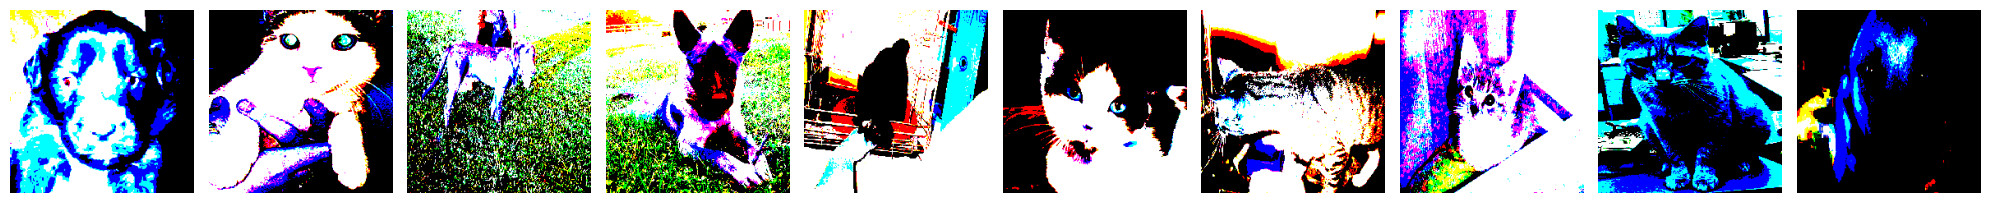

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [202]:
plotImages(imgs) 
display(labels)

# building the model itself
it's composed of 2 packs of a convolutional layer plus a MaxPool.  
the model afterwards needs to be compiles and then fitted.  
This model in particular didnt work so well, with alow accuracy of validation of around 60%. Which indicates a overfitting on the training dataset.  
After that, we'll 'import' a already working model. 

In [203]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(), Dense(units=2, activation='softmax')
])

In [204]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_6 (Dense)             (None, 2)                 4

In [205]:
if os.path.isfile('./catdog_model.h5') is False:
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
    if os.path.isfile('./catdog_model.h5') is False:
        model.save('./catdog_model.h5')

else: imported_model = load_model('./catdog_model.h5') 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

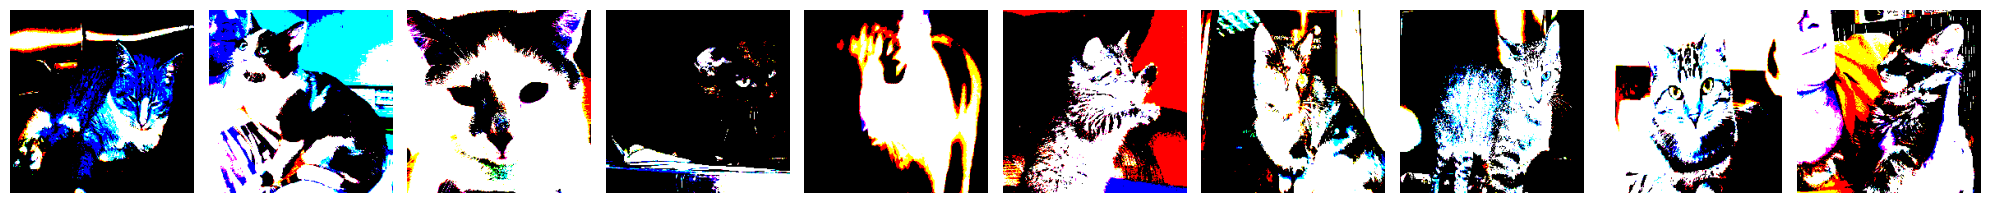

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [206]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [207]:
predictions = model.predict(test_batches, verbose=0)
np.round(predictions)

2023-07-19 21:05:02.581144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-19 21:05:02.692093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2023-07-19 21:05:02.858174: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2023-07-19 21:05:02.974756: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2023-07-19 21:05:03.093912: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2023-07-19 21:05:03.216023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.

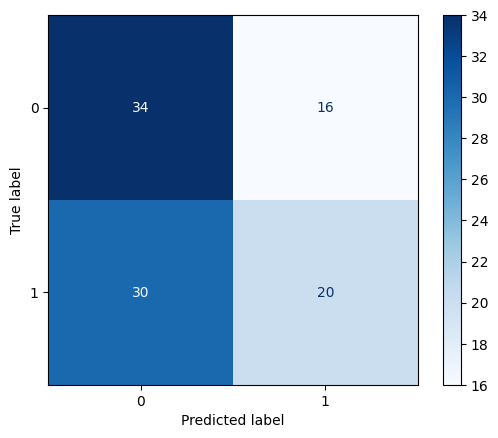

In [208]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

ConfusionMatrixDisplay(cm).plot(cmap='Blues');

# importing VGG16 model

In [209]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [210]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [211]:
print(type(model), type(vgg16_model), sep='\n')

<class 'keras.engine.sequential.Sequential'>
<class 'keras.engine.functional.Functional'>


note that these two model have different properties, as the past model being a Sequential model, and the VGG being a API called Model, which is far more complicated for now, so we're going to 'transform' it to a sequential model -->

In [212]:
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [213]:
for layer in model.layers:
    layer.trainable=False 
''' 
setting the layer to be non trainable because its already trained, 
but it has  a lot of classes, rather than just cat and dogs. After that
we add a new Dense layer, that will set our predictions to be just cats and dogs.
That means just this layer will have a trainable parameters, as we can see in the summary.
'''
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

                                                                 
 block3_pool (MaxPooling2D)  (None, 28, 28, 256)       0         
                                                                 
 block4_conv1 (Conv2D)       (None, 28, 28, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 14, 14, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_co

In [216]:
if os.path.isfile('./vgg_trained.h5') is False:
    model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_batches, validation_data=valid_batches, epochs=2, verbose=2)
    model.save('./vgg_trained.h5')
else: model = load_model('./vgg_trained.h5')

Epoch 1/2


2023-07-19 21:12:14.964161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 - 348s - loss: 0.0842 - accuracy: 0.9640 - val_loss: 0.0905 - val_accuracy: 0.9500 - 348s/epoch - 3s/step
Epoch 2/2
100/100 - 349s - loss: 0.0471 - accuracy: 0.9830 - val_loss: 0.0754 - val_accuracy: 0.9600 - 349s/epoch - 3s/step


2023-07-19 21:33:22.084994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


<Figure size 640x480 with 0 Axes>

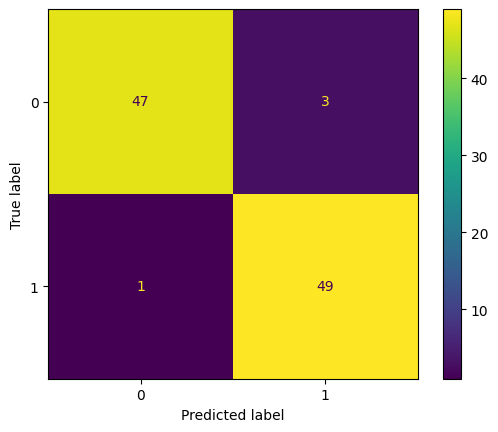

In [220]:
vgg_pred = model.predict(test_batches, verbose=0)
vgg_cm = confusion_matrix(test_batches.classes, y_pred=np.argmax(vgg_pred, axis=-1))

plt.figure()
disp = ConfusionMatrixDisplay(vgg_cm)
disp.plot()
plt.show()


# MobileNets

mobile net is a light weight model that is applied in mobile applications

## Prep

In [23]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [36]:
def prepare_image(file):
    img_path = 'dogs-vs-cats/train/'
    img = image.load_img(img_path + file, target_size = (224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dim = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dim)

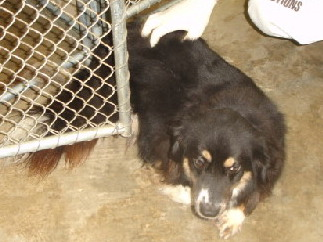

In [29]:
from IPython.display import Image
Image('dogs-vs-cats/train/dog/dog.jpg')

In [37]:
preprocessed_img = prepare_image('dog/dog1007.jpg')
prediction = mobile.predict(preprocessed_img)
results = imagenet_utils.decode_predictions(prediction)
results

1/1 [==============================] - 0s 55ms/step


[[('n02108551', 'Tibetan_mastiff', 0.4868923),
  ('n02107683', 'Bernese_mountain_dog', 0.13038446),
  ('n02106550', 'Rottweiler', 0.12321595),
  ('n02111500', 'Great_Pyrenees', 0.11728779),
  ('n02107908', 'Appenzeller', 0.020873575)]]

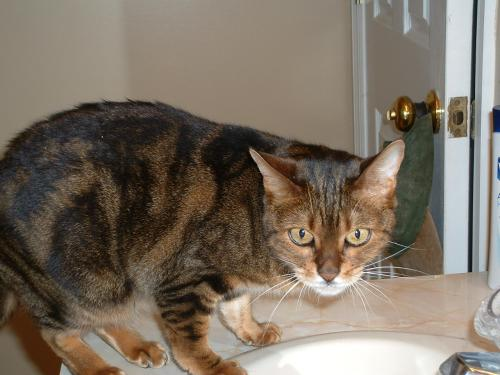

1/1 [==============================] - 0s 77ms/step


[[('n02124075', 'Egyptian_cat', 0.52335626),
  ('n02123045', 'tabby', 0.3183669),
  ('n02123159', 'tiger_cat', 0.09430448),
  ('n03207941', 'dishwasher', 0.020724997),
  ('n04040759', 'radiator', 0.003934074)]]

In [41]:
image2 = 'cat/cat2170.jpg'

display(Image('./dogs-vs-cats/train/'+image2))

preprocessed_img = prepare_image(image2)
prediction = mobile.predict(preprocessed_img)
results = imagenet_utils.decode_predictions(prediction)
results

## Train Mobile net for a specific dataset

In [221]:
sign_path = './Sign-Language-Digits-Dataset-master/Dataset/'

if os.path.isdir(sign_path+'train') is False:
    os.mkdir(sign_path+'train')
    os.mkdir(sign_path+'test')
    os.mkdir(sign_path+'valid')
    print('mkdirs ok')

    for i in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        shutil.move(sign_path+f'{i}',sign_path+'train')
        os.mkdir(sign_path+f'valid/{i}')
        os.mkdir(sign_path+f'test/{i}')
        print('train/test/valid mkdir ok')

        valid_samples = random.sample(os.listdir(sign_path+f'train/{i}'), 30)
        for v in valid_samples:
            shutil.move(sign_path+f'train/{i}/{v}', sign_path+f'valid/{i}')
        print('valid samples ok')

        test_samples = random.sample(os.listdir(sign_path+f'train/{i}'), 5)
        for t in test_samples:    
            shutil.move(sign_path+f'train/{i}/{t}', sign_path+f'test/{i}')
        print('test samples ok')
else: print('the directory is ready')

the directory is ready


In [222]:
for i in range(0,10):
    assert len(os.listdir(sign_path+f'valid/{i}')) == 30
    assert len(os.listdir(sign_path+f'test/{i}')) == 5

In [223]:
sign_train_path = sign_path+'train'
sign_valid_path = sign_path+'valid'
sign_test_path =  sign_path+'test'

'''
Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. 
Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset 
with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, 
as well as the preprocessing layer guide.
'''

sign_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory=sign_train_path, target_size=(224,224), batch_size=10)
sign_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory=sign_valid_path, target_size=(224,224), batch_size=10)
sign_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory=sign_test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [224]:
assert sign_train_batches.n == 1712
assert sign_test_batches.n == 50
assert sign_valid_batches.n == 300
assert sign_train_batches.num_classes == sign_valid_batches.num_classes  == sign_test_batches.num_classes  == 10

## Modifying the Original MobileNet

In [225]:
sign_mobile = tf.keras.applications.mobilenet.MobileNet()
sign_mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [226]:
# here she found out that "droping" the last 6 layers resulted in a better modeling
# til the global_average_pooling2d_3 layer
x = sign_mobile.layers[-5].output # this is confusing but x is the layer up to the -6th layer, without the last ones
x = tf.keras.layers.Flatten()(x) # this layer needed to be added after a update on the base code
output = Dense(units=10, activation='softmax')(x) # here this selection is added a last Dense layer
sign_model = Model(inputs=sign_mobile.input, outputs=output) # and at last a new model (Functional, different from Sequential) where it come sthis inputs and outputs

In [227]:
for layer in sign_model.layers[:-23]: # she found out that this was the best setting to this model, training just the last 23 layers
    layer.trainable=False

sign_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [228]:
if os.path.isfile('./sign-model.h5') is False:
    sign_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    sign_model.fit(x=sign_train_batches, validation_data=sign_valid_batches, epochs=10, verbose=2)
    sign_model.save('./sign-model.h5')

else: sign_model = load_model('./sign-model.h5') 

In [229]:
sign_test_labels = sign_test_batches.classes
sign_predictions = sign_model.predict(sign_test_batches, verbose=0)
cm = confusion_matrix(y_true=sign_test_labels, y_pred=sign_predictions.argmax(axis=1))

display(sign_test_batches.class_indices)

2023-07-19 21:37:12.962017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

<Figure size 640x480 with 0 Axes>

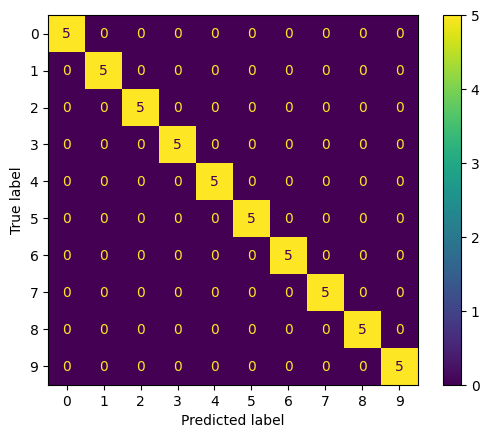

In [240]:
ax = plt.figure()
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(0,10))
disp.plot()
if os.path.isfile('./figures/cm_sign.png') is False:
    ax.savefig('./figures/cm_sign.png')
plt.show()

# Image augmentation

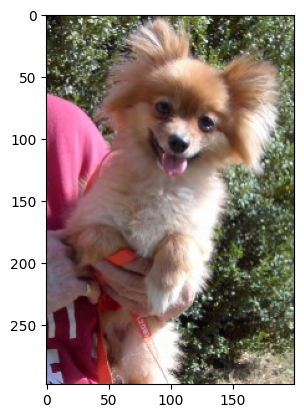

In [231]:
dog_path ='./dogs-vs-cats/train/dog/'
image_path = dog_path + random.choice(os.listdir(dog_path))
dog_image = plt.imread(image_path)
plt.imshow(dog_image)

dog_image=np.expand_dims(dog_image,0)

In [232]:
augmentation = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                                  height_shift_range=0.2, zoom_range=0.3, horizontal_flip=True )
aug_iter = augmentation.flow(dog_image)

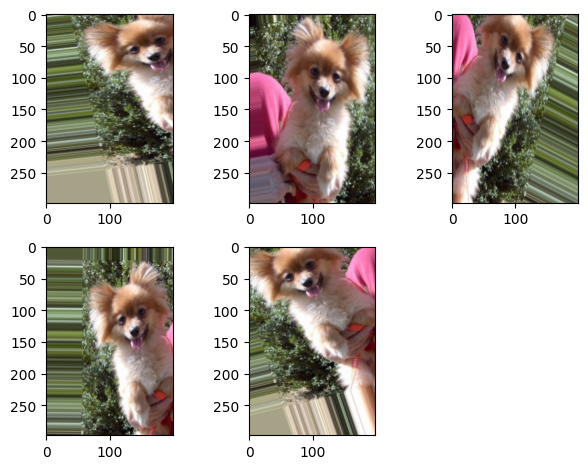

In [233]:
dog_images = [next(aug_iter)[0].astype(np.uint8) for i in range(5)]
i=1
for dog in dog_images:
    plt.subplot(2,3,i)
    i+=1
    plt.imshow(dog)
plt.tight_layout()
plt.show()